In [1]:
import librosa, librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.layers import LSTM, TimeDistributed ,Reshape
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


Data preprocessing

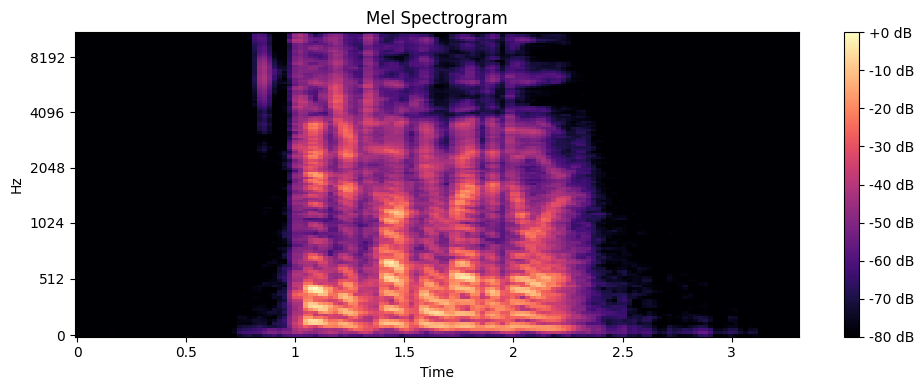

In [2]:

# Waveform
# Mel spectrogram
y, sr = librosa.load(r"data\Actor_01\03-01-01-01-01-01-01.wav")
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
S_dB = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(10, 4))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title("Mel Spectrogram")
plt.tight_layout()
plt.show()


In [3]:
# Emotions map from RAVDESS filename (3rd part in filename)
emotion_dict = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

In [4]:
def get_emotion(path):
    filename = os.path.basename(path)
    emotion_code = filename.split("-")[2]
    emotion = emotion_dict.get(emotion_code, "unknown")
    return emotion

In [5]:

def standarize(mfccs, max_len=340):
    """
    MFCC convert into standard shape (n_mfcc, max_len) .
    
    Args:
        mfcc: numpy array of shape (n_mfcc, time_frames)
        max_len: target time frame length (default 300)

    Returns:
        standardized mfcc of shape (n_mfcc, max_len)
    """
    standardized_mfccs = []
    for mfcc in mfccs:    
        n_mfcc, t = mfcc.shape
        
        if t < max_len:  # padding
            pad_width = max_len - t
            mfcc_padded = np.pad(mfcc, ((0,0), (0, pad_width)), mode='constant')
            standardized_mfccs.append(mfcc_padded)
        
        elif t > max_len:  # truncation
            standardized_mfccs.append(mfcc[:, :max_len])
        
        else:  # already equal
            standardized_mfccs.append(mfcc)
    return np.array(standardized_mfccs)


In [6]:


def plot_mfcc_curves(mfcc_list, labels, n_coeffs=5):
    """
    Plot MFCC curves for multiple audio samples.

    Parameters:
    - mfcc_list: list of numpy arrays, each with shape (n_mfcc, time_frames)
    - labels: list of emotion labels corresponding to each mfcc
    - n_coeffs: number of MFCC coefficients to plot (default=40)
    """
    n_samples = len(mfcc_list)
    rows = n_samples // 4 + (1 if n_samples % 4 != 0 else 0)
    cols = min(4, n_samples)

    fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 4))
    axes = axes.flatten()

    for idx, (mfcc, label) in enumerate(zip(mfcc_list, labels)):
        ax = axes[idx]
        time = np.arange(mfcc.shape[1])  # time axis from frames
        for i in range(min(n_coeffs, mfcc.shape[0])):  
            ax.plot(time, mfcc[i], label=f"MFCC {i+1}",marker='o', markersize=2)
        ax.set_title(label)
        ax.set_xlabel("Time Frames")
        ax.set_ylabel("Coefficient Value")
        ax.legend()

    # Hide empty subplots if any
    for j in range(idx+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


In [7]:
import os
import librosa
from tqdm import tqdm
data = []
label = []
dataset_path = r"data/"   # root dataset path


for root, dirs, files in (os.walk(dataset_path)):
    for file in files:
        if file.endswith(".wav"):
            file_path = os.path.join(root, file)
            print(f"Processing {file_path}...")
            
            # Load audio
            y, sr = librosa.load(file_path, sr=None)
            # Extract MFCC features
            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
            data.append(mfccs)
            label.append(get_emotion(file))  



Processing data/Actor_01\03-01-01-01-01-01-01.wav...
Processing data/Actor_01\03-01-01-01-01-02-01.wav...
Processing data/Actor_01\03-01-01-01-02-01-01.wav...
Processing data/Actor_01\03-01-01-01-02-02-01.wav...
Processing data/Actor_01\03-01-02-01-01-01-01.wav...
Processing data/Actor_01\03-01-02-01-01-02-01.wav...
Processing data/Actor_01\03-01-02-01-02-01-01.wav...
Processing data/Actor_01\03-01-02-01-02-02-01.wav...
Processing data/Actor_01\03-01-02-02-01-01-01.wav...
Processing data/Actor_01\03-01-02-02-01-02-01.wav...
Processing data/Actor_01\03-01-02-02-02-01-01.wav...
Processing data/Actor_01\03-01-02-02-02-02-01.wav...
Processing data/Actor_01\03-01-03-01-01-01-01.wav...
Processing data/Actor_01\03-01-03-01-01-02-01.wav...
Processing data/Actor_01\03-01-03-01-02-01-01.wav...
Processing data/Actor_01\03-01-03-01-02-02-01.wav...
Processing data/Actor_01\03-01-03-02-01-01-01.wav...
Processing data/Actor_01\03-01-03-02-01-02-01.wav...
Processing data/Actor_01\03-01-03-02-02-01-01.

In [8]:
len(data)

2880

In [9]:

data = standarize(data, max_len=300)


DATA VISUALS

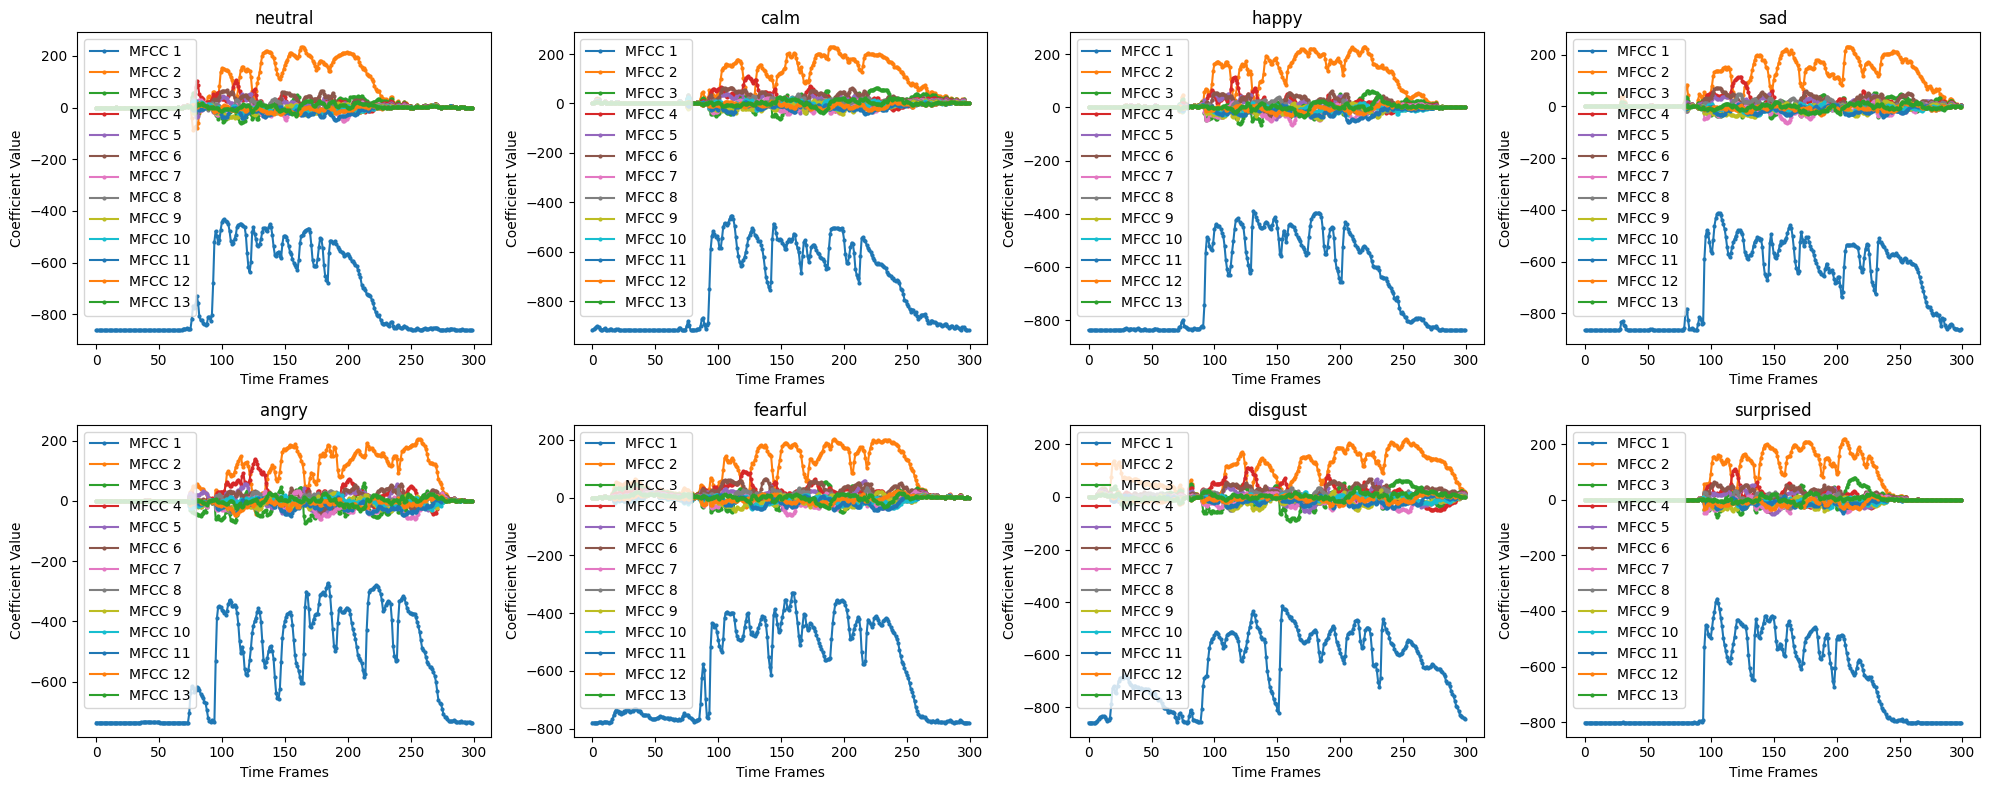

In [10]:
unique_graph = [data[0],data[4],data[12],data[20],data[28],data[36],data[44],data[52]]
unique_labels = [label[0],label[4],label[12],label[20],label[28],label[36],label[44],label[52]]
plot_mfcc_curves(unique_graph, labels=unique_labels, n_coeffs=13)


In [11]:

scaler = StandardScaler()
X = data.reshape(data.shape[0], -1)  # flatten
X = scaler.fit_transform(X)
X = X.reshape(-1, 40, 300, 1)

# data = [...]   # list of MFCC arrays
# labels = [...] # list of emotion strings


le = LabelEncoder()
y = le.fit_transform(label)   # e.g. ['happy','sad'] → [2,5]

y = to_categorical(y)
print("Final dataset shape:", X.shape, y.shape)  
# Example: (1440, 300, 40), (1440, 8)

# Step 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)


Final dataset shape: (2880, 40, 300, 1) (2880, 8)
Train shape: (2304, 40, 300, 1) (2304, 8)
Test shape: (576, 40, 300, 1) (576, 8)


In [12]:
le.inverse_transform([0,1,2,3,4,5,6,7])

['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad','surprised']

['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

CNN MODEL TRAINING

In [13]:

model = Sequential([
    Conv2D(32, (2,2), activation='relu', input_shape=(40, 300, 1)),
    BatchNormalization(),
    MaxPooling2D((2,2)),   # height=5 is small, so pool only in width
    Conv2D(64, (2,2), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(128, (2,2), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((1,2)),

    Conv2D(256, (2,2), activation='relu'),
    # BatchNormalization(),
    MaxPooling2D((1,2)),

    Conv2D(128, (2,2), activation='relu'),
    # BatchNormalization(),
    MaxPooling2D((1,2)),

    Conv2D(64, (2,2), activation='relu'),
    # BatchNormalization(),
    MaxPooling2D((1,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(8, activation='softmax')   # 8 emotions
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 39, 299, 32)       160       
                                                                 
 batch_normalization (BatchN  (None, 39, 299, 32)      128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 19, 149, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 148, 64)       8256      
                                                                 
 batch_normalization_1 (Batc  (None, 18, 148, 64)      256       
 hNormalization)                                                 
                                                        

In [14]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [15]:

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
72/72 [==============================] - 9s 41ms/step - loss: 1.9561 - accuracy: 0.2383 - val_loss: 2.0682 - val_accuracy: 0.1441
Epoch 2/50
72/72 [==============================] - 3s 36ms/step - loss: 1.6329 - accuracy: 0.3854 - val_loss: 2.2148 - val_accuracy: 0.1580
Epoch 3/50
72/72 [==============================] - 3s 37ms/step - loss: 1.2507 - accuracy: 0.5334 - val_loss: 2.5472 - val_accuracy: 0.1823
Epoch 4/50
72/72 [==============================] - 3s 36ms/step - loss: 0.8848 - accuracy: 0.6918 - val_loss: 2.3066 - val_accuracy: 0.2674
Epoch 5/50
72/72 [==============================] - 3s 37ms/step - loss: 0.5460 - accuracy: 0.8142 - val_loss: 1.7089 - val_accuracy: 0.4514
Epoch 6/50
72/72 [==============================] - 3s 36ms/step - loss: 0.3535 - accuracy: 0.8789 - val_loss: 0.7972 - val_accuracy: 0.7326
Epoch 7/50
72/72 [==============================] - 3s 37ms/step - loss: 0.1860 - accuracy: 0.9418 - val_loss: 0.4227 - val_accuracy: 0.8559
Epoch 8/50
72

MODEL EVALUATION


18/18 [==============================] - 0s 19ms/step


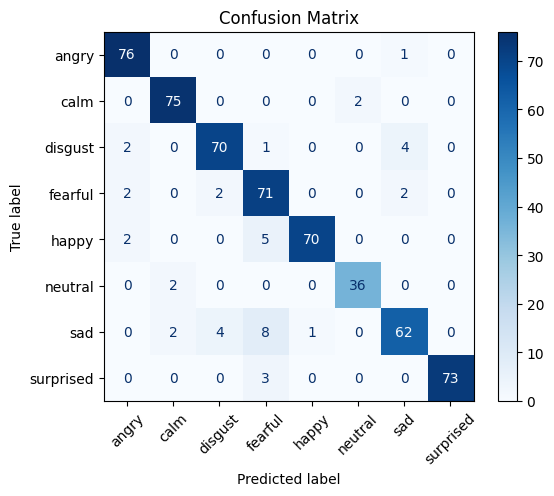

In [ ]:


# Predict classes for test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

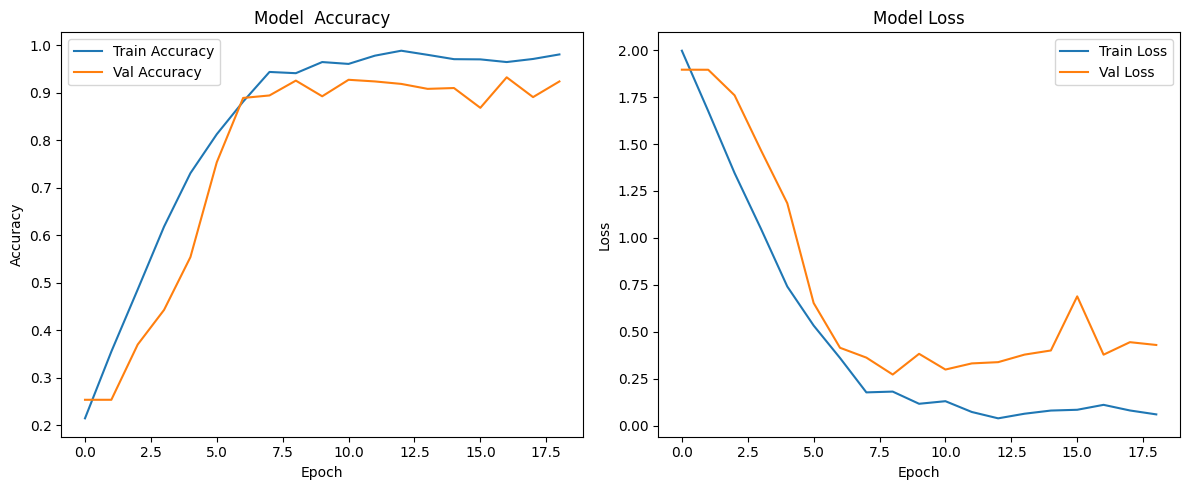

In [20]:
plt.figure(figsize=(12,5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model  Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
# Evaluate test set par
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc * 100, "%")

18/18 [==============================] - 0s 11ms/step - loss: 0.2716 - accuracy: 0.9253
Test Accuracy: 92.53472089767456 %


In [ ]:
model.save('emotion_model_92.h5')

EVALUATE THE MODEL WITH RANDOM DATA

In [27]:
# 1. Load the audio file
y_new, sr_new = librosa.load(r"data\Actor_01\03-01-01-01-01-01-01.wav", sr=sr)

# 2. Extract MFCC features (same as training)
mfcc_new = librosa.feature.mfcc(y=y_new, sr=sr_new, n_mfcc=40)

# 3. Standardize shape (same as training)
mfcc_new_std = standarize([mfcc_new], max_len=300)  # returns shape (1, 40, 300)

# 4. Reshape for model input (add channel dimension)
mfcc_new_std = mfcc_new_std.reshape(1, 40, 300, 1)

# 5. Predict
pred = model.predict(mfcc_new_std)

pred_class = np.argmax(pred, axis=1)[0]
pred_label = le.inverse_transform([pred_class])[0]
# print("Prediction probabilities:", pred)

print("Predicted emotion:", pred_label)

1/1 [==============================] - 0s 20ms/step
Predicted emotion: neutral
